<a href="https://colab.research.google.com/github/KaElmas/Language-as-Data/blob/main/KOPIE_Assignment1_ElmasKat_2828399_FinalVersion_AdvancedNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Assignment 1: Feature-Based Semantic Role Labeling (SRL) with Logistic Regression

##### Task
I build a feature-based SRL system that predicts semantic role labels for each token **given a specific predicate**.

- Predicates are given (I do not detect predicates).
- Classification unit: **a token given a predicate**.

##### Preprocessing idea
A sentence can have multiple predicates.
So I **duplicate each sentence once per predicate**.

##### Model
- Logistic Regression (token-level classification)

##### Exactly 3 features
1. **F1 (required, combined)**: dependency path (token → predicate) + predicate lemma  
   - MUST be combined into **one string** feature value.
2. **F2**: linear position of token relative to predicate (BEFORE / AFTER / PRED)
3. **F3**: named entity type of token (PERSON / ORG / LOC / DATE / ... or O)

##### Why these features?
Central questions:
- How does my token relate to my predicate (syntax)? → F1
- What does my predicate mean (semantics)? → F1 (predicate lemma)
- What does my token mean (semantics)? → F3 (NER type)
Extra useful cue:
- Where is the token relative to predicate? → F2

##### Outputs
- Print dataset statistics before/after preprocessing
- Print feature examples (human-readable)
- Classification report + confusion matrix
- Save predictions TSV file
- Save model + vectorizer
- Inference function (tokens + predicate mask → labels)


In [1]:
!pip install stanza


In [2]:
import os
import csv
import pickle
from collections import Counter, defaultdict

import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from pathlib import Path

TRAIN_PATH = Path("/content/en_ewt-up-train.conllu")
DEV_PATH   = Path("/content/en_ewt-up-dev.conllu")
TEST_PATH  = Path("/content/en_ewt-up-test.conllu")


assert os.path.exists(TRAIN_PATH), "Train file not found."
assert os.path.exists(DEV_PATH), "Dev file not found."
assert os.path.exists(TEST_PATH), "Test file not found."

print("Files found!")


Files found!


##### Window parameters

I limit the amount of data by maximum number of token rows.

These values are chosen to avoid Colab RAM crashes.
You can increase them later if your runtime has more memory.


In [4]:
MAX_TOKENS_TRAIN = 80_000
MAX_TOKENS_TEST  = 20_000

print("MAX_TOKENS_TRAIN =", MAX_TOKENS_TRAIN)
print("MAX_TOKENS_TEST  =", MAX_TOKENS_TEST)


MAX_TOKENS_TRAIN = 80000
MAX_TOKENS_TEST  = 20000


###### Stanza parsing (self-sufficient feature extraction)

The dataset contains lemma/POS/dependency columns, but this assignment requires that feature extraction is self-sufficient:
in real usage, we only have:
- tokens
- predicate position

So I use **Stanza** to compute:
- dependency parse (heads + dependency relations)
- lemmas (for predicate lemma)
- named entities (NER types like PERSON/ORG/LOC)

I use `tokenize_pretokenized=True` so Stanza keeps my tokenization.


In [5]:
import stanza

stanza.download("en")

# Build pipeline: tokenize + pos + lemma + depparse + ner
# tokenize_pretokenized=True keeps tokens unchanged
nlp = stanza.Pipeline(
    "en",
    processors="tokenize,pos,lemma,depparse,ner",
    tokenize_pretokenized=True,
    verbose=False
)

print("Stanza pipeline ready!")


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


Stanza pipeline ready!


In [6]:
def stanza_parse_all(tokens):
    """
    tokens: list[str]
    returns:
      heads: list[int]   0-based head index, ROOT = -1
      deprels: list[str]
      lemmas: list[str]
      ner_tags: list[str] token-level NER type (PERSON/ORG/LOC/DATE/... or "O")
    """
    doc = nlp([tokens])
    sent = doc.sentences[0]

    # dependency + lemma (word-level)
    heads, deprels, lemmas = [], [], []
    for w in sent.words:
        heads.append(-1 if w.head == 0 else w.head - 1)
        deprels.append(w.deprel if w.deprel else "dep")
        lemmas.append(w.lemma.lower() if w.lemma else w.text.lower())

    # token-level NER from entity spans
    ner_tags = ["O"] * len(sent.tokens)
    for ent in sent.ents:
        ent_type = ent.type
        for tok in ent.tokens:
            idx = tok.id[0] - 1  # token id is 1-based
            if 0 <= idx < len(ner_tags):
                ner_tags[idx] = ent_type

    return heads, deprels, lemmas, ner_tags


###### Reading Universal PropBank CoNLL-U format

Each token line has at least 10 columns (UD format).
Column 10 (index 9) contains a predicate sense label (like `kill.01`) or `_`.

Columns 11+ contain SRL labels.
There is one SRL label column per predicate in that sentence.

Preprocessing:
- If a sentence has N predicates, I create N duplicated instances.
- Each instance uses SRL labels for exactly one predicate column.


In [7]:
def read_conllu_sentences(file_path):
    """
    Returns list of sentence dicts:
      {
        "sent_id": str or None,
        "text": str or None,
        "rows": list[list[str]]  # tab-split token lines
      }

    Skips:
    - comment lines (# ...)
    - multiword tokens (IDs like 1-2)
    - empty nodes (IDs like 2.1)
    """
    sentences = []
    current_rows = []
    sent_id = None
    text = None

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")

            if line.startswith("# sent_id"):
                sent_id = line.split("=", 1)[1].strip()
                continue
            if line.startswith("# text"):
                text = line.split("=", 1)[1].strip()
                continue

            if line.strip() == "":
                if current_rows:
                    sentences.append({"sent_id": sent_id, "text": text, "rows": current_rows})
                current_rows = []
                sent_id = None
                text = None
                continue

            if line.startswith("#"):
                continue

            cols = line.split("\t")
            if len(cols) < 10:
                continue

            tok_id = cols[0]
            if "-" in tok_id or "." in tok_id:
                continue

            current_rows.append(cols)

    if current_rows:
        sentences.append({"sent_id": sent_id, "text": text, "rows": current_rows})

    return sentences

train_sents = read_conllu_sentences(TRAIN_PATH)
dev_sents   = read_conllu_sentences(DEV_PATH)
test_sents  = read_conllu_sentences(TEST_PATH)

print("Loaded sentences:", len(train_sents), len(dev_sents), len(test_sents))


Loaded sentences: 12543 2002 2077


In [8]:
def stats_before(sentences):
    num_sent = len(sentences)
    num_tok = sum(len(s["rows"]) for s in sentences)
    return num_sent, num_tok

print("BEFORE preprocessing")
print("Train:", stats_before(train_sents))
print("Dev:  ", stats_before(dev_sents))
print("Test: ", stats_before(test_sents))


BEFORE preprocessing
Train: (12543, 204585)
Dev:   (2002, 25148)
Test:  (2077, 25096)


###### Preprocessing: duplicate each sentence per predicate

A sentence can have multiple predicates (multiple predicate sense labels in column 10).
For SRL training we need one instance per predicate, so:

- If a sentence has 2 predicates, create 2 duplicated instances.
- Each instance keeps the same tokens, but uses the SRL labels for only one predicate column.

I also store:
- predicate_index (token position of the predicate)
- predicate_sense (e.g., kill.01) for debugging
But I do NOT use predicate sense as a feature for disambiguation.

In [9]:
def duplicate_per_predicate(sentence):
    """
    Creates one instance per predicate.
    Each instance has:
      - tokens
      - gold_labels for that predicate
      - predicate_index
      - predicate_sense (debug only)
    """
    rows = sentence["rows"]
    tokens = [r[1] for r in rows]  # FORM column

    predicate_positions = []
    predicate_senses = []
    for i, r in enumerate(rows):
        pred = r[9]  # predicate sense or "_"
        if pred != "_":
            predicate_positions.append(i)
            predicate_senses.append(pred)

    if len(predicate_positions) == 0:
        return []

    # SRL columns start at index 10
    num_srl_cols = max(0, len(rows[0]) - 10)
    num_instances = min(num_srl_cols, len(predicate_positions))

    instances = []
    for p_idx in range(num_instances):
        pred_i = predicate_positions[p_idx]
        pred_sense = predicate_senses[p_idx]

        gold_labels = []
        for r in rows:
            col = 10 + p_idx
            gold_labels.append(r[col] if len(r) > col else "O")

        instances.append({
            "sent_id": sentence["sent_id"],
            "text": sentence["text"],
            "tokens": tokens,
            "gold_labels": gold_labels,
            "predicate_index": pred_i,
            "predicate_sense": pred_sense  # debug only
        })

    return instances


def preprocess(sentences):
    all_instances = []
    dropped_no_pred = 0
    for s in sentences:
        insts = duplicate_per_predicate(s)
        if not insts:
            dropped_no_pred += 1
        all_instances.extend(insts)
    return all_instances, dropped_no_pred

train_inst, train_dropped = preprocess(train_sents)
dev_inst, dev_dropped     = preprocess(dev_sents)
test_inst, test_dropped   = preprocess(test_sents)

print("Dropped (no predicates): Train", train_dropped, "Dev", dev_dropped, "Test", test_dropped)
print("Instances (duplicates): Train", len(train_inst), "Dev", len(dev_inst), "Test", len(test_inst))


Dropped (no predicates): Train 1364 Dev 310 Test 397
Instances (duplicates): Train 25159 Dev 3269 Test 3231


In [10]:
def stats_after(instances):
    num_inst = len(instances)
    num_tok = sum(len(x["tokens"]) for x in instances)
    return num_inst, num_tok

print("AFTER preprocessing (instances = duplicates per predicate)")
print("Train:", stats_after(train_inst))
print("Dev:  ", stats_after(dev_inst))
print("Test: ", stats_after(test_inst))


AFTER preprocessing (instances = duplicates per predicate)
Train: (25159, 609517)
Dev:   (3269, 63102)
Test:  (3231, 62128)


##### Feature definitions (EXACTLY 3 features)

##### F1 (required, combined)
Directed dependency path from token to predicate + predicate lemma
**IMPORTANT:** this must be ONE combined string feature value, for example:
`UP:nsubj|UP:root|DOWN:obj||PREDLEM=kill`

##### F2 (linear position)
Token position relative to predicate:
- BEFORE
- AFTER
- PRED (token is the predicate)

##### F3 (named entity type)
Token NER type from Stanza:
- PERSON, ORG, LOC, DATE, ...
- or O (no named entity)

These three features complement each other:
- F1 gives syntax relation + predicate meaning
- F2 gives surface order cue
- F3 gives token semantics (coarse)


### Dependency path helper functions

In [11]:
def path_to_root(i, heads):
    path = []
    while i != -1:
        path.append(i)
        i = heads[i]
        if i is None:
            break
    return path

def dep_path_token_to_pred(tok_i, pred_i, heads, deprels):
    if tok_i == pred_i:
        return "SELF"

    tok_path = path_to_root(tok_i, heads)
    pred_path = path_to_root(pred_i, heads)

    tok_set = set(tok_path)
    lca = None
    for node in pred_path:
        if node in tok_set:
            lca = node
            break
    if lca is None:
        return "NO_PATH"

    # UP steps: token -> LCA
    up_steps = []
    cur = tok_i
    while cur != lca:
        up_steps.append(f"UP:{deprels[cur]}")
        cur = heads[cur]

    # DOWN steps: LCA -> predicate
    down_nodes = []
    cur = pred_i
    while cur != lca:
        down_nodes.append(cur)
        cur = heads[cur]
    down_nodes.reverse()
    down_steps = [f"DOWN:{deprels[n]}" for n in down_nodes]

    steps = up_steps + down_steps
    return "|".join(steps) if steps else "LCA"


### Feature 2 Linear Position

In [12]:
def linear_position(tok_i, pred_i):
    if tok_i < pred_i:
        return "BEFORE"
    if tok_i > pred_i:
        return "AFTER"
    return "PRED"

#### Final feature extractor

In [13]:
def extract_features_for_instance(tokens, pred_i):
    """
    Returns list[dict] length = len(tokens)
    Each dict contains EXACTLY 3 features.
    """
    heads, deprels, lemmas, ner_tags = stanza_parse_all(tokens)
    pred_lemma = lemmas[pred_i]

    feats = []
    for i in range(len(tokens)):
        path = dep_path_token_to_pred(i, pred_i, heads, deprels)

        # F1 MUST BE COMBINED INTO ONE STRING
        f1_combined = f"{path}||PREDLEM={pred_lemma}"

        f2 = linear_position(i, pred_i)
        f3 = ner_tags[i]  # PERSON/ORG/LOC/... or O

        feats.append({
            "F1_path_predlemma": f1_combined,
            "F2_linear_position": f2,
            "F3_ner_type": f3
        })

    return feats


##### Feature sanity check (human-readable examples)

I print extracted features for a few instances BEFORE vectorization.
For each shown token I display:
- token text
- gold label
- 3-feature dictionary


In [14]:
def print_feature_example(instances, n=2, max_tokens=15):
    for idx in range(min(n, len(instances))):
        inst = instances[idx]
        tokens = inst["tokens"]
        pred_i = inst["predicate_index"]
        gold = inst["gold_labels"]

        feats = extract_features_for_instance(tokens, pred_i)

        print("="*80)
        print("sent_id:", inst["sent_id"])
        print("predicate_index:", pred_i, "| predicate_sense (debug):", inst["predicate_sense"])
        print("text:", inst["text"])
        print("-"*80)

        for i in range(min(max_tokens, len(tokens))):
            print(f"{i:02d}  {tokens[i]:15s}  GOLD={gold[i]:10s}  FEATS={feats[i]}")
        print()

print_feature_example(train_inst, n=2, max_tokens=15)

sent_id: weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
predicate_index: 0 | predicate_sense (debug): SpaceAfter=No
text: Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
--------------------------------------------------------------------------------
00  Al               GOLD=_           FEATS={'F1_path_predlemma': 'SELF||PREDLEM=al', 'F2_linear_position': 'PRED', 'F3_ner_type': 'PERSON'}
01  -                GOLD=_           FEATS={'F1_path_predlemma': 'UP:punct|UP:flat||PREDLEM=al', 'F2_linear_position': 'AFTER', 'F3_ner_type': 'PERSON'}
02  Zaman            GOLD=_           FEATS={'F1_path_predlemma': 'UP:flat||PREDLEM=al', 'F2_linear_position': 'AFTER', 'F3_ner_type': 'PERSON'}
03  :                GOLD=_           FEATS={'F1_path_predlemma': 'UP:punct|UP:parataxis||PREDLEM=al', 'F2_linear_position': 'AFTER', 'F3_ner_type': 'O'}
04  American         GOLD=_           FEATS={'F1_pa

##### Build X/y with token-row window (no cache)

To avoid RAM crashes, I limit the number of token rows.
- Train: MAX_TOKENS_TRAIN
- Test:  MAX_TOKENS_TEST

I keep meta only for test (needed to write prediction file).


In [15]:
def build_xy_limited(instances, max_tokens, keep_meta=True, print_every=200):
    X, y = [], []
    meta = [] if keep_meta else None

    token_counter = 0

    for idx, inst in enumerate(instances):
        if print_every and idx % print_every == 0:
            print(f"Processing instance {idx}/{len(instances)} | tokens so far={token_counter}")

        tokens = inst["tokens"]
        pred_i = inst["predicate_index"]
        gold = inst["gold_labels"]

        feats = extract_features_for_instance(tokens, pred_i)

        for i in range(len(tokens)):
            if token_counter >= max_tokens:
                return X, y, meta

            X.append(feats[i])
            y.append(gold[i])

            if keep_meta:
                meta.append({
                    "sent_id": inst["sent_id"],
                    "predicate_index": pred_i,
                    "token_index": i,
                    "token": tokens[i],
                    "gold": gold[i]
                })

            token_counter += 1

    return X, y, meta


In [16]:
X_train, y_train, _ = build_xy_limited(train_inst, max_tokens=MAX_TOKENS_TRAIN, keep_meta=False, print_every=200)
print("Train token rows:", len(X_train))

X_test, y_test, meta_test = build_xy_limited(test_inst, max_tokens=MAX_TOKENS_TEST, keep_meta=True, print_every=100)
print("Test token rows:", len(X_test))


Processing instance 0/25159 | tokens so far=0
Processing instance 200/25159 | tokens so far=7296
Processing instance 400/25159 | tokens so far=13446
Processing instance 600/25159 | tokens so far=19174
Processing instance 800/25159 | tokens so far=26040
Processing instance 1000/25159 | tokens so far=32380
Processing instance 1200/25159 | tokens so far=37977
Processing instance 1400/25159 | tokens so far=43663
Processing instance 1600/25159 | tokens so far=50265
Processing instance 1800/25159 | tokens so far=56127
Processing instance 2000/25159 | tokens so far=61539
Processing instance 2200/25159 | tokens so far=66374
Processing instance 2400/25159 | tokens so far=73910
Processing instance 2600/25159 | tokens so far=78581
Train token rows: 80000
Processing instance 0/3231 | tokens so far=0
Processing instance 100/3231 | tokens so far=2920
Processing instance 200/3231 | tokens so far=6720
Processing instance 300/3231 | tokens so far=10130
Processing instance 400/3231 | tokens so far=11840

#### Vectorize and train Logistic Regression

I vectorize with DictVectorizer and train Logistic Regression.
I delete large objects after use to reduce RAM usage.


In [17]:
vec = DictVectorizer(sparse=True)
X_train_vec = vec.fit_transform(X_train)
del X_train  # free RAM

clf = LogisticRegression(
    max_iter=200,
    solver="saga",
    n_jobs=-1
)
clf.fit(X_train_vec, y_train)
del X_train_vec, y_train  # free RAM

print("Model trained!")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model trained!


In [18]:
X_test_vec = vec.transform(X_test)
del X_test  # free RAM

y_pred = clf.predict(X_test_vec)

print(classification_report(y_test, y_pred, digits=4))

labels = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=labels)
print("Confusion matrix shape:", cm.shape)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

                         0.0000    0.0000    0.0000       289
                ARG0     0.0000    0.0000    0.0000       175
                ARG1     0.0000    0.0000    0.0000       280
                ARG2     0.0000    0.0000    0.0000       104
                ARG3     0.0000    0.0000    0.0000         6
                ARG4     0.0000    0.0000    0.0000         5
            ARGM-ADJ     0.0000    0.0000    0.0000        13
            ARGM-ADV     0.0000    0.0000    0.0000        63
            ARGM-CAU     0.0000    0.0000    0.0000         2
            ARGM-COM     0.0000    0.0000    0.0000         3
            ARGM-DIR     0.0000    0.0000    0.0000         1
            ARGM-DIS     0.0000    0.0000    0.0000        17
            ARGM-EXT     0.0000    0.0000    0.0000         5
            ARGM-GOL     0.0000    0.0000    0.0000         1
            ARGM-LOC     0.0000    0.0000    0.0000        14
       

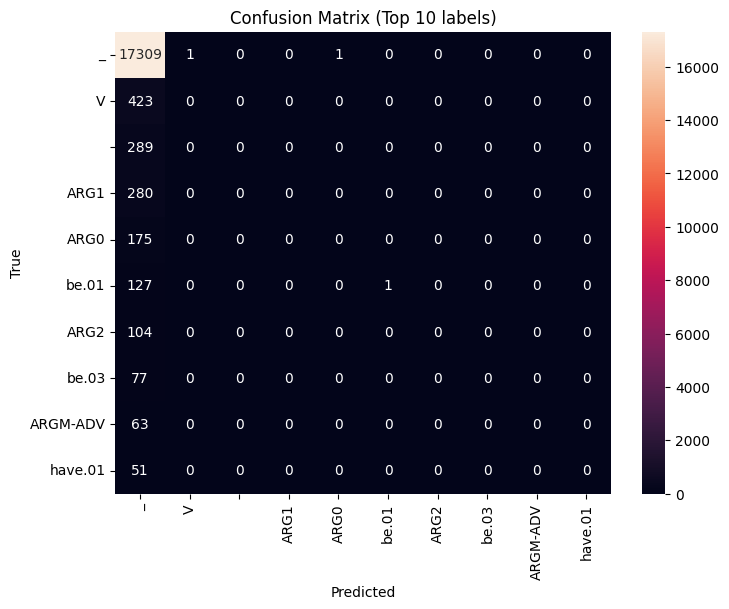

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# pick top frequent labels
from collections import Counter
label_counts = Counter(y_test)
top_labels = [l for l,_ in label_counts.most_common(10)]

cm_small = confusion_matrix(y_test, y_pred, labels=top_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_small, annot=True, fmt="d",
            xticklabels=top_labels,
            yticklabels=top_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Top 10 labels)")
plt.show()


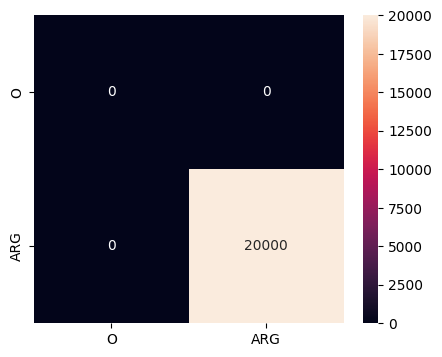

In [22]:
y_test_binary = ["O" if y=="O" else "ARG" for y in y_test]
y_pred_binary = ["O" if y=="O" else "ARG" for y in y_pred]

cm_binary = confusion_matrix(y_test_binary, y_pred_binary, labels=["O","ARG"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_binary, annot=True, fmt="d",
            xticklabels=["O","ARG"],
            yticklabels=["O","ARG"])
plt.show()


##### Save predictions to TSV

I save a TSV file containing:
- sent_id
- predicate_index
- token_index
- token
- gold label
- predicted label

This file is useful for debugging and is required output.


In [19]:
PRED_PATH = "srl_predictions_test.tsv"

with open(PRED_PATH, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["sent_id", "predicate_index", "token_index", "token", "gold", "pred"])
    for m, pred in zip(meta_test, y_pred):
        writer.writerow([m["sent_id"], m["predicate_index"], m["token_index"], m["token"], m["gold"], pred])

print("Saved:", PRED_PATH)


Saved: srl_predictions_test.tsv


##### Save model and vectorizer

The assignment says not to upload the model to Canvas.
So I save the model and vectorizer locally, and later I can upload them to a public place (e.g., Google Drive).


In [20]:
with open("srl_logreg_model.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("srl_dictvectorizer.pkl", "wb") as f:
    pickle.dump(vec, f)

print("Saved model and vectorizer.")


Saved model and vectorizer.


#### Inference function

Input:
- tokens
- predicate_mask (0/1 list, exactly one 1)

Output:
- predicted SRL labels for each token


In [23]:
def predict_srl(tokens, predicate_mask, model, vectorizer):
    assert len(tokens) == len(predicate_mask)
    assert sum(predicate_mask) == 1

    pred_i = int(np.argmax(predicate_mask))
    feats = extract_features_for_instance(tokens, pred_i)
    X_vec = vectorizer.transform(feats)
    return list(model.predict(X_vec))

tokens = ["I", "saw", "him", "leave", "."]
mask_saw   = [0,1,0,0,0]
mask_leave = [0,0,0,1,0]

print("Predicate=saw:  ", predict_srl(tokens, mask_saw, clf, vec))
print("Predicate=leave:", predict_srl(tokens, mask_leave, clf, vec))


Predicate=saw:   [np.str_('_'), np.str_('_'), np.str_('_'), np.str_('_'), np.str_('_')]
Predicate=leave: [np.str_('_'), np.str_('_'), np.str_('_'), np.str_('_'), np.str_('_')]


####Discussion

1. Task and evaluation setup

In this assignment, the classification unit is a token given a specific predicate. The predicate is already given in the data, so the model does not need to find predicates. Instead, the model must assign a semantic role label (like, ARG0, ARG1, ARGM-LOC, or no-role) to every token, separately for each predicate in the sentence. Because one sentence can contain multiple predicates, I duplicate each sentence once per predicate and create one training instance per (sentence, predicate). This makes the problem a standard supervised token classification task.

For evaluation, I used a windowed subset of the data (due to memory constraints) and reported:

- a classification report (precision / recall / F1 per label)
- overall accuracy
- macro average and weighted average scores

and also a confusion matrix (full size is not readable because there are many labels, so I also inspected smaller versions).

2. Feature design (what each feature contributes)

I used exactly three features:

- F1 (obligatory): dependency_path + predicate_lemma (combined into one string)

This is the most important feature. It captures two things at the same time:

Syntax: how the token is connected to the predicate in the dependency tree (the dependency path).

Predicate semantics: the lemma of the predicate gives information about what event/action is expressed.

The assignment requirement says the obligatory feature must be “combined”. I did this by creating a single string value such as:

UP:nsubj|UP:root|DOWN:obj||PREDLEM=kill

This is essential for logistic regression. If the path and lemma were separate features, logistic regression would treat them independently and would not correctly model their interaction. With a combined string, the model can learn weights for patterns that are specific to a predicate lemma (e.g., “nsubj path + predicate=kill” is different from “nsubj path + predicate=say”).


- F2: linear position (BEFORE / AFTER / PRED)

This feature encodes whether the token appears before or after the predicate in the sentence. The motivation is that in English, subjects are often before the verb and objects are often after the verb, so position can help distinguish likely roles.

However, linear position is a very coarse feature: many arguments and adjuncts can appear both before and after the predicate. Also, in longer sentences with subclauses, position becomes less informative because a token can be far away from its predicate. So this feature may add only a small improvement, and it cannot fix deeper structural problems by itself.


- F3: named entity type (NER)

This feature provides coarse semantics of the token. If a token is a PERSON, it is more likely to be an agent-like argument in many contexts. For instance, if it is a LOC, it may correspond to location modifiers (ARGM-LOC), etc. NER also helps reduce sparsity. So instead of learning separate weights for each unique name, the model can learn a weight for the category PERSON.

This feature is generally compatible with logistic regression because it is a discrete feature (one-hot after vectorization).

3. Results and what they mean

My results show:

- Accuracy ≈ 0.8655

- Weighted F1 ≈ 0.80

- Macro F1 ≈ 0.002

Many labels (around 476 in the confusion matrix)

This combination of metrics is very informative.

3.1 High accuracy / weighted F1 but extremely low macro F1

The huge gap between weighted and macro metrics indicates severe class imbalance.

Accuracy is dominated by the most frequent class.

Weighted F1 is also dominated by frequent classes because classes with many examples get more weight.

Macro F1 treats every class equally (rare classes count the same as frequent classes). A very low macro F1 means that the model performs poorly on most rare labels.

In SRL data, the “no role” label (often O or _) is extremely common. Most tokens in a sentence are not arguments for a given predicate. Therefore, a model can achieve high accuracy simply by predicting the most frequent “no-role” class for many tokens. This explains why the overall accuracy can look good even when the model fails to predict semantic roles for rarer labels.

4. Confusion matrix analysis (what the model is actually doing)

A full confusion matrix with 476 labels is not practically readable, so I inspected smaller versions:

4.1 Top-10 label confusion matrix

The top-label confusion matrix shows a strong concentration in one predicted class. Many true labels are mapped into the same predicted label. This suggests the model learns a strong bias toward the most frequent label(s), and it does not separate rare argument labels well.

4.2 Binary O vs ARG analysis

I also created a binary view where:

- O = no semantic role

- ARG = any non-O label

This binary confusion matrix is helpful to answer one key question:
Does the model mostly predict “no argument”?

The matrix shows that the model tends to treat many tokens as the same broad category instead of learning fine-grained roles. This supports the macro-F1 result: even if the model can classify the most common label correctly, it does not generalize well to specific role labels.

5. Why logistic regression struggles here (model limitations)

Logistic regression is a linear classifier. It assigns a score using a weighted sum of features. This is good for sparse, discrete features. However it still has important limitations for SRL:

- 5.1 No global constraints

SRL has structure: typically one predicate has at most one ARG0, etc., and arguments form a coherent set. Logistic regression predicts each token independently, so it cannot enforce global constraints or consistency.

- 5.2 Interaction effects are hard

Some linguistic phenomena require feature interactions (like, voice, long-distance dependencies, clause boundaries). Logistic regression does not automatically learn complex feature interactions unless we explicitly create combined features. The obligatory feature is one such interaction feature (path + pred lemma), but many other interactions remain unmodeled.

- 5.3 Large label set + imbalance

With hundreds of labels, many labels have very few training examples. Logistic regression can struggle to learn reliable parameters for rare classes, especially when the model sees overwhelmingly many “no-role” examples.

6. Discussion of the linear position feature (F2)

It is reasonable to suspect that linear position is not very strong in this setting. The feature is simple and often helps slightly in English. Howeevr it can become weak because of several reasons. For instance:

- Tokens can be before the predicate for many reasons (topic, subclause, fronting).

- Tokens after the predicate can be objects, adjuncts, or parts of other clauses.

- The same role can appear both before and after the predicate.

- It does not encode distance, clause boundaries, or syntactic function.

So basically, F2 may not add much compared to the obligatory dependency-path feature, which already captures much richer syntactic information. However, F2 is still a valid feature for logistic regression and is easy to interpret.

7. Data and computational constraints (windowing)

To avoid RAM crashes in Colab, I trained and evaluated on a subset of token rows. This does not change the model or feature definitions, it only limits the amount of training data processed in a single run. Because the obligatory feature (path + predicate lemma) creates a large number of unique feature values, the sparse feature space grows quickly. Therefore, windowing is to me a practical solution to run the experiment under limited memory.

8. What I would improve next (useful for assignment 2)

Based on the results, the main issue is not that the feature set is “wrong”, but that the model is strongly affected by class imbalance and the complexity of SRL.

Possible improvements (conceptual):

- Class weighting in logistic regression (class_weight="balanced") to penalize mistakes on rare roles more.

- Reducing label space (e.g., map very rare labels to an “OTHER” group) for analysis purposes.

- Adding features that are still logistic-regression-friendly but give extra structure, such as:

dependency relation of the token to its head,

whether the token is in the same clause as the predicate,

distance buckets (near/far) to predicate,

POS tag or coarse POS (if allowed).

In Assignment 2 (transformer-based SRL), a transformer can better model long-range context and semantic information and can learn richer interactions automatically.

9. Conclusion

The obligatory combined feature (dependency path + predicate lemma) provides a strong syntactic and semantic signal. The model achieves relatively high accuracy and weighted F1. However, the extremely low macro F1 and the confusion matrix analysis indicate that the model does not perform well on rare semantic roles. Probably mostly due to severe label imbalance and the limitations of token-independent linear classification. Overall, this experiment shows that feature-based logistic regression can capture frequent patterns but struggles to generalize to the full semantic role inventory. This motivates to work with more powerful sequence models in later assignments.